# Simplified code for 1D example


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm, trange
from math import exp, sqrt, log
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import i0, i1, iv
from numpy import random
from torch.nn.functional import normalize
import matplotlib.pyplot as plt
%matplotlib inline

/home/pengxy2024/miniconda3/envs/QPDE/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type('torch.cuda.FloatTensor')
#device = torch.device("cpu")

In [4]:
class PDEQnet(nn.Module):
  def __init__(self, dim, width, beta):
    super(PDEQnet, self).__init__()
    self.dim = dim
    self.width = width
    self.innerwidth = int(width/2)
    self.beta = beta

    self.wb = nn.Linear(self.dim, self.width).to(device)
    self.wb2 = nn.Linear(self.width, self.width).to(device)
    self.c = nn.Linear(self.width, 1, bias=False).to(device)

  def forward(self, x):
    x = self.wb(x)
    x = torch.sigmoid(x)
    # x = 1/(1+torch.pow(x,2))
    # x = self.wb2(x)
    # x = torch.sigmoid(x)
    # x = 1/(1+torch.pow(x,2))
    x = self.c(x)
    return x

  def assign_value(self):
    self.c.weight.data = torch.as_tensor(np.random.uniform(-1, 1, size=self.c.weight.shape), dtype=torch.float32).to(device)
    self.wb.weight.data = torch.as_tensor(np.random.normal(0, 1, size=self.wb.weight.shape),  dtype=torch.float32).to(device)
    self.wb.bias.data = torch.as_tensor(np.random.normal(0, 1, size=self.wb.bias.shape) ,dtype=torch.float32).to(device)
    self.wb2.weight.data = torch.as_tensor(np.random.normal(0, 1, size=self.wb2.weight.shape),  dtype=torch.float32).to(device)
    self.wb2.bias.data = torch.as_tensor(np.random.normal(0, 1, size=self.wb2.bias.shape) ,dtype=torch.float32).to(device)


In [5]:
# Parameters
dim = 1
gamma = 0.1

#d = [1 for i in range(dim)]

# Hyper parameters
N = 2**6
beta = 0.5+0.01
# Learning rate
# initial_lr = 0.02 #* N**(2*beta-1)
initial_lr = 0.5

# Auxiliary functions
def eta(grid):
  res = 1 -  torch.pow(grid,2)
  return res



# Monte Carlo
Nmc_max = 2000
Nmc_min = 1000
Nbasepoints = int(1e7)
# Default type


In [6]:
# Q fit, fixed grid
qnet = PDEQnet(dim, N, beta).to(device)
# initialization of PDEQnet paramters
qnet.assign_value()


In [7]:
#qnet.load_state_dict(torch.load('/content/6d, Q-learning, 30k epochs.pkl'))

In [8]:
# Create reservoir of points, so we don't have to sample every loop
#this is maybe the one thing that's worth doing on a GPU

#source = torch.randn(size=(Nbasepoints, dim))
#source = normalize(source, p=2.0) #Normalize to sphere
#radius = torch.rand(size = (Nbasepoints,1))
#radius = torch.pow(torch.rand(size = (Nbasepoints,1)),1/dim)
#source = radius*source #renormalize

source = torch.rand(size=(Nbasepoints,1))*2-1


  0%|          | 0/60000 [00:00<?, ?it/s]

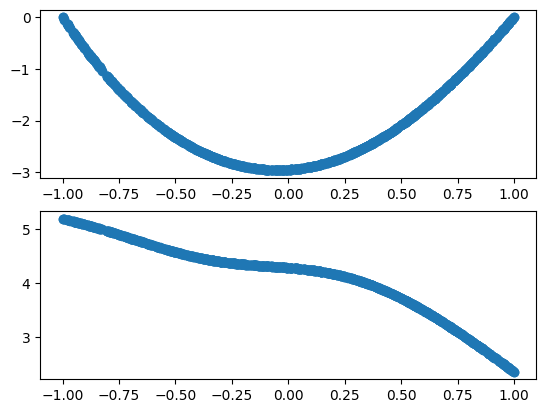

100%|██████████| 60000/60000 [08:17<00:00, 120.49it/s]


In [9]:
#Training algorithm, main

# Num of epoch
Num_epo = 60000

# Loss level
loss_list = []

# Optmizer, scheduler
# Qoptimizer = optim.RMSprop(qnet.parameters(), lr = initial_lr, alpha = 0.99, eps = 1e-08)
Qoptimizer = optim.Adam(qnet.parameters(), lr = initial_lr)
Qscheduler = LambdaLR(Qoptimizer, lr_lambda= lambda epoch: initial_lr/(1+(epoch//200)))

fig, axs = plt.subplots(2,1)

# Training
for count in trange(Num_epo):

  Nmc = int(Nmc_min+(Nmc_max-Nmc_min)*(1+count)/(1+Num_epo))
  epoch_sample = torch.randint(0,len(source), (Nmc,1))

  grid = source[epoch_sample].clone().detach()
  grid.requires_grad = True
  
  # Net output
  v = qnet(grid)
  v = v*eta(grid).reshape(v.shape)

  # Tensor reshape
  v_r =  torch.reshape(v, (-1,))
  # Compute partial derivatives and the Laplacian
  dv_dx = torch.autograd.grad(v, grid, grad_outputs = torch.ones(grid.size()), create_graph = True)[0]
  d2v_dx2 = torch.autograd.grad(dv_dx, grid, grad_outputs = torch.ones(grid.size()), create_graph = True)[0]
  dv_dx = torch.reshape(dv_dx, (-1,))
  d2v_dx2 = torch.reshape(d2v_dx2, (-1,))
  
  #evaluate PDE operator
  lq = 1 - gamma*v_r + 0.5* d2v_dx2
  LQ = lq.clone().detach()

  # Q-learning
  loss_to_min =-1* torch.dot(LQ, v_r)
  #with torch.cuda.stream(s):
  Qoptimizer.zero_grad()
  loss_to_min.backward()
  Qoptimizer.step()
  Qscheduler.step()

  loss = float(torch.dot(LQ, LQ))
  loss/= Nmc
  loss_list.append(loss)

  if count%20 == 0:
    axs[0].clear()
    axs[1].clear()
    axs[0].scatter(grid.detach().cpu(),v_r.detach().cpu())
    axs[1].scatter(grid.detach().cpu(), LQ.detach().cpu())
    plt.pause(0.01)



In [10]:
#model_save_name = 'BM, 6d, 30k epochs.pkl'
#path = F"/content/{model_save_name}" 
#torch.save(qnet.state_dict(), path)

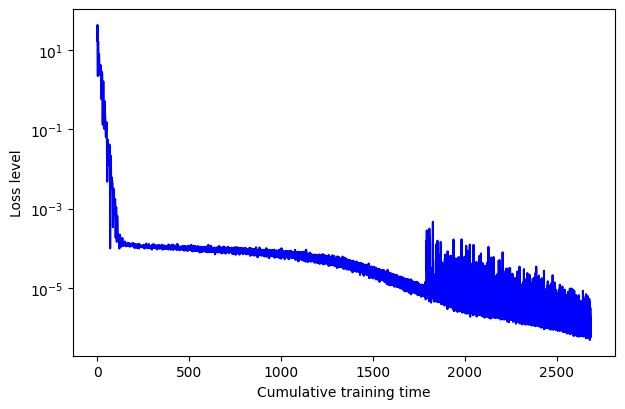

In [11]:
# Loss level
plt.figure(figsize=(7,4.5))
#ax = fig.add_subplot(1, 2, 1)
axis=[i for i in range(Num_epo)]
axis = np.cumsum([1/(1+(i//500)) for i in range(Num_epo)])
plt.xlabel('Cumulative training time')
plt.ylabel('Loss level')
plt.yscale('log') 
fig1 = plt.plot(axis,loss_list,'blue')

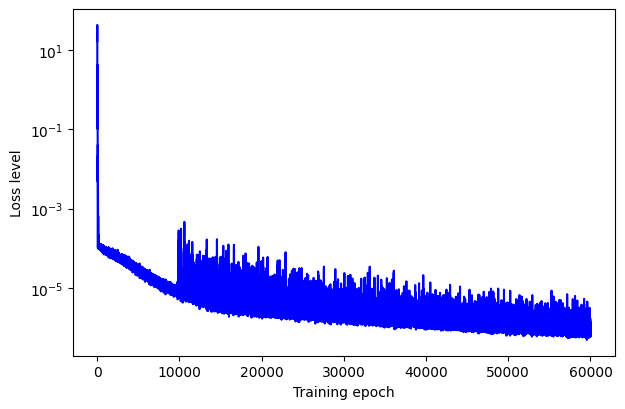

In [12]:
# Loss level
plt.figure(figsize=(7,4.5))
#ax = fig.add_subplot(1, 2, 1)
axis=[i for i in range(Num_epo)]
plt.xlabel('Training epoch')
plt.ylabel('Loss level')
plt.yscale('log') 
fig1 = plt.plot(axis,loss_list,'blue')

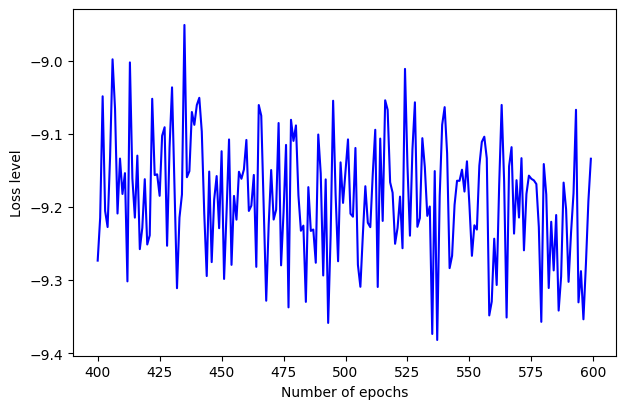

In [13]:
log_loss_list = [log(x) for x in loss_list]
plt.figure(figsize=(7,4.5))
#ax = fig.add_subplot(1, 2, 1)
axis=[i for i in range(Num_epo)]
plt.xlabel('Number of epochs')
plt.ylabel('Loss level')
fig1 = plt.plot(axis[400:600], log_loss_list[400:600],'blue')

In [20]:

# Plotting part 1: # Check if the approximator is symmetric
Nmc = 800
mesh = 2000

test_axis = [-1.0 + 2.0*i/mesh for i in range(mesh)]
relative_err_list = []
approx_list = []
sq_list = []
exact_list = []

radius = 1.0
for x in test_axis:
  # exact = (1 - iv(2, sqrt(2*gamma)*x)/(x*x*iv(2, sqrt(2*gamma))))/gamma
  exact = (1 - (exp(sqrt(2*gamma)*x) + exp(-sqrt(2*gamma)*x))/(exp(sqrt(2*gamma)) + exp(-sqrt(2*gamma))))/gamma
  exact_list.append(exact)
  test_source = random.normal(-1, 1, size=(Nmc//10, dim))
  test_source = torch.Tensor(test_source)
  test_source = normalize(test_source, p=2.0)
  test_source = x * test_source

  test_grid_list = []
  for i in range(dim):
    ent = [[u] for u in test_source[:,i]]
    ent = torch.tensor(ent, requires_grad = True).to(device)
    test_grid_list.append(ent)
  test_grid_tuple = tuple(test_grid_list)
  test_grid = torch.cat(test_grid_tuple, 1).to(device)

  test_out = qnet(test_grid).to(device)

# Tensor reshape
  test_out_r =  torch.reshape(test_out, (-1,)).to(device)
  test_l = test_out_r*eta(test_grid)
  sq_list.append(float(torch.max(test_l-exact) * torch.max(test_l-exact)))
  # relative_err_list.append(float(torch.max(abs((exact - test_l)/exact))))
  relative_err_list.append(float(torch.mean(abs(((exact - test_l)/exact)))))
  approx_list.append(float(torch.mean(test_l)))

In [21]:
# Plotting part 2
# Scatter plot #Test: the solution vs the approximator
scatter_axis = test_axis * (Nmc//10)
# relative_err_list = []
approx_list = []
std_list = []


for x in scatter_axis:
  test_source = random.normal(0, 1, size=(1, dim))
  test_source = torch.Tensor(test_source)
  test_source = normalize(test_source, p=2.0)
  test_source = x * test_source

  test_grid_list = []
  for i in range(dim):
    ent = [[u] for u in test_source[:,i]]
    ent = torch.tensor(ent, requires_grad = True).to(device)
    test_grid_list.append(ent)
  test_grid_tuple = tuple(test_grid_list)
  test_grid = torch.cat(test_grid_tuple, 1).to(device)

  test_out = qnet(test_grid).to(device)

# Tensor reshape
  test_out_r =  torch.reshape(test_out, (-1,)).to(device)
  test_l = test_out_r*eta(test_grid)
  approx_list.append(float(torch.mean(test_l)))


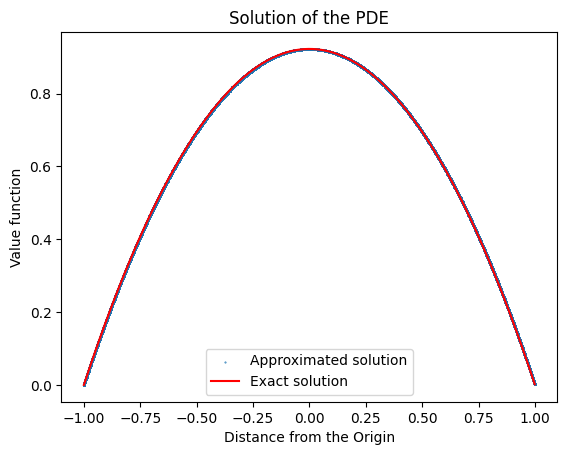

In [22]:
# Exact vs Approximate
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('Distance from the Origin')
ax.set_ylabel('Value function')
ax.set_title('Solution of the PDE')
ax.scatter(scatter_axis, approx_list, s= .2, label = 'Approximated solution')
ax.plot(test_axis, exact_list,'red', label = 'Exact solution')
ax.legend()
# axins = ax.inset_axes([0.05,0.05, 0.5, 0.5])
# scatter_data_zoom = [approx_list[i] for i in range(len(scatter_axis)) if (0.48 < scatter_axis[i]  < 0.51)]
# scatter_axis_zoom = [item for item in scatter_axis if (0.48 < item < 0.51)]
# line_data_zoom = [exact_list[i] for i in range(len(test_axis)) if (0.48 < test_axis[i] < 0.51)]
# line_axis_zoom = [item for item in test_axis if (0.48 < item < 0.51)]
# axins.scatter(scatter_axis_zoom, scatter_data_zoom, s=.1)
# axins.plot(line_axis_zoom, line_data_zoom, 'red')
# axins.set_xticks([])
# axins.set_yticks([])
# ax.indicate_inset_zoom(axins)

Text(0.5, 1.0, 'Mean square error of the approximator')

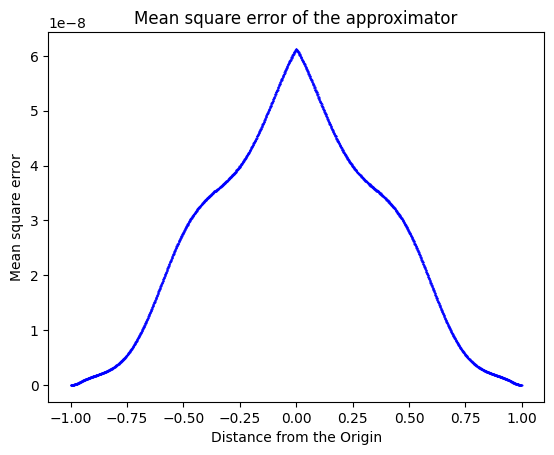

In [23]:
# Mean square error
plt.xlabel('Distance from the Origin')
plt.ylabel('Mean square error')
plt.scatter(test_axis, sq_list,color = 'blue', s= .2)
plt.title('Mean square error of the approximator')

/home/pengxy2024/miniconda3/envs/QPDE/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


Text(0.5, 1.0, 'MaxRelative error in percentage')

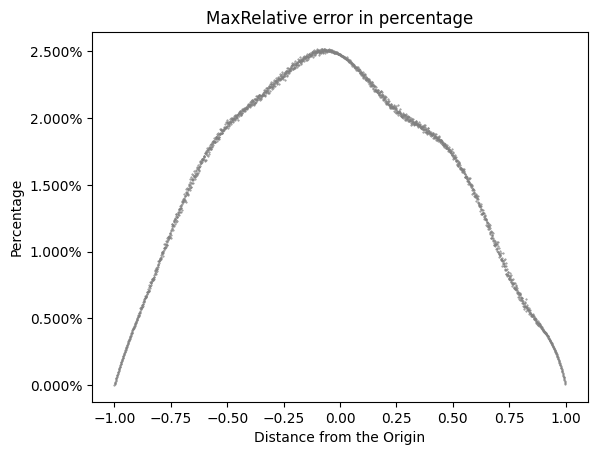

In [24]:
# Max relative error
plt.xlabel('Distance from the Origin')
plt.ylabel('Percentage')
# print(len(test_axis), len(relative_err_list))
plt.scatter(test_axis, relative_err_list, s=0.2, color='gray',)

plt.gca().set_yticklabels([f'{x:.3%}' for x in plt.gca().get_yticks()]) 
plt.title('MaxRelative error in percentage')